In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from brukeropusreader import read_file
from scipy.interpolate import interp1d
import os
import pandas as pd
import numpy as np
import shap  
from scipy.interpolate import interp1d
from brukeropusreader import read_file
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Define folder paths (corrected paths for RE and OE)
folder_path_oe = 'Spectra RE'  # OE data actually in 'Spectra RE'
folder_path_re = 'Spectra OE'  # RE data actually in 'Spectra OE'
folder_path_trachea = 'Spectra TR'  # Trachea data is correct

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)  # Actually RE data in 'Spectra OE'
files_oe = list_files(folder_path_oe)  # Actually OE data in 'Spectra RE'
files_tr = list_files(folder_path_trachea)  # Trachea data in 'Spectra TR'

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_tr)}")
print("Files:", files_tr)


RE Folder:
Number of files: 185
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '20240415 B3 OE.0001', '20240415 B4 OE.0003', '20240415 B4 OE.0004', '20240408 A3 OE.0001', '20240408 A4 OE.0003', '05022024 OE 5 mit max druck.0001'

In [3]:
# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

First wavenumber: 5000
Last wavenumber: 400
Total number of points: 4601


In [4]:
def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Assuming wavenumbers are stored in a key 'WN' in the returned data
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    # Generate the list of wavenumbers
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

In [5]:
def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

In [6]:
def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

In [7]:
def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

In [8]:
def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        
        # Cut the spectra to the wavenumbers from 800 to 1900 cm⁻¹
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)


In [9]:
# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))


First wavenumber: 5000
Last wavenumber: 400
Total number of points: 4601


In [10]:
# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)

# Wrapper class for SHAP compatibility
class DecisionTreeClassifierWithTrees(DecisionTreeClassifier):
    @property
    def trees(self):
        return [shap.SingleTree(self.tree_, normalize=True)]



Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 8), ('min_samples_leaf', 1), ('min_samples_split', 2)])
              precision    recall  f1-score   support

          OE       0.61      0.53      0.57        36
          RE       0.57      0.79      0.67        29
     Trachea       0.96      0.79      0.87        33

    accuracy                           0.69        98
   macro avg       0.72      0.70      0.70        98
weighted avg       0.72      0.69      0.70        98



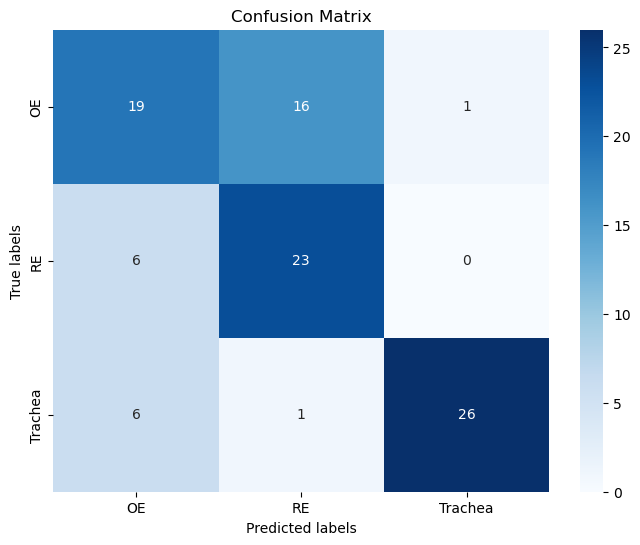

Cross-validation scores: [0.80612245 0.73469388 0.71428571 0.84693878 0.79381443]
Average score: 0.78
Standard deviation of scores: 0.05


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

# Split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Define the mask for filtering wavenumbers
mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)

# Define the hyperparameter search space for Decision Tree
search_space = {
    'max_depth': Integer(1, 20),  # Depth of the tree
    'min_samples_split': Integer(2, 10),  # Minimum samples to split a node
    'min_samples_leaf': Integer(1, 10),  # Minimum samples at a leaf node
    'criterion': Categorical(['gini', 'entropy']),  # Splitting criterion
}

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Initialize Bayesian Optimization search
bayes_search = BayesSearchCV(
    model,
    search_spaces=search_space,
    n_iter=30,  # Number of optimization iterations
    cv=5,       # Cross-validation strategy
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

# Perform the search for the best hyperparameters
bayes_search.fit(X_train, y_train)

# Best parameters found by Bayesian Optimization
print(f"Best parameters: {bayes_search.best_params_}")

# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report and confusion matrix
class_names = ['OE', 'RE', 'Trachea']
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Perform 10-fold cross-validation on the best model
scores = cross_val_score(best_model, X, y, cv=5)

# Calculate and print the average and standard deviation of the scores
average_score = np.mean(scores)
std_deviation = np.std(scores)

print("Cross-validation scores:", scores)
print("Average score:", f"{average_score:.2f}")
print("Standard deviation of scores:", f"{std_deviation:.2f}")


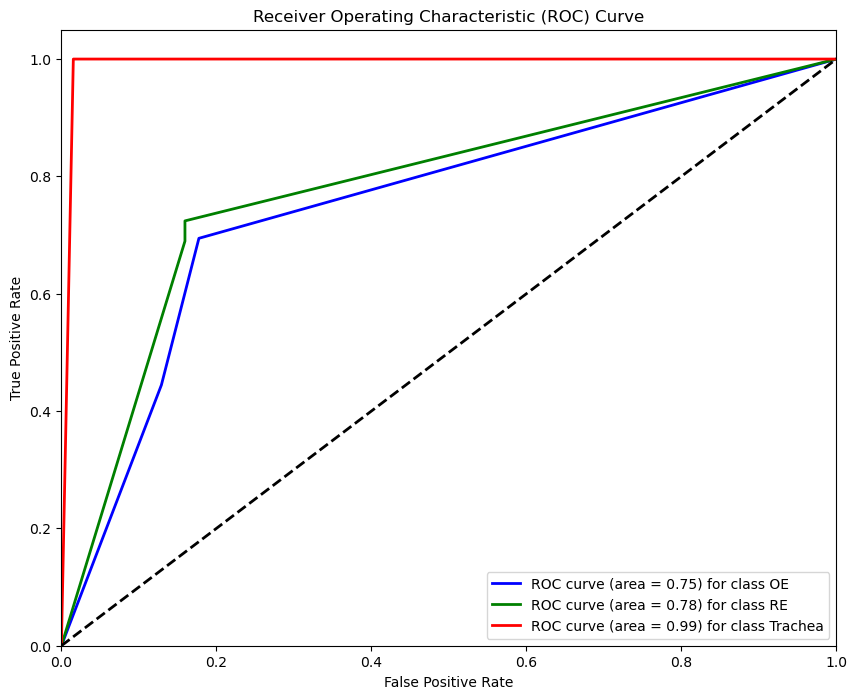

Macro-average ROC AUC score: 0.84
Micro-average ROC AUC score: 0.84


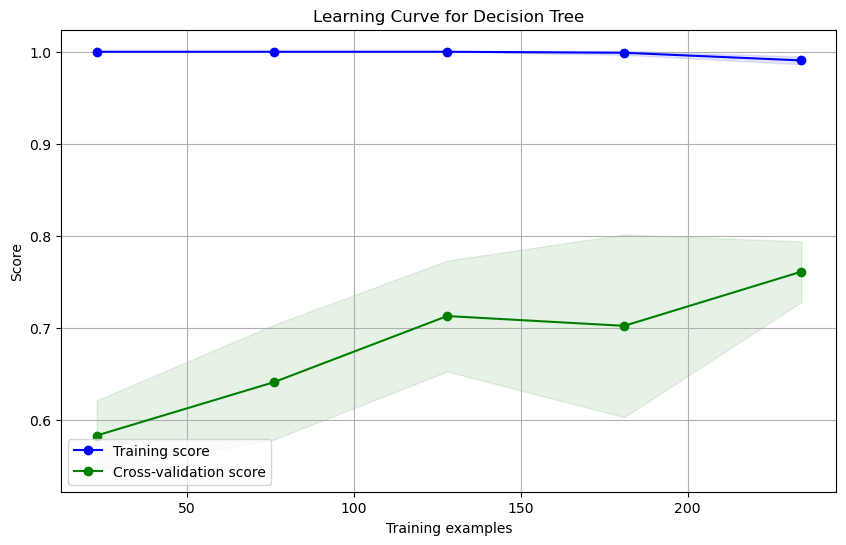

In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Fit the model using One-vs-Rest strategy for multi-class classification
classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
class_names = ['OE', 'RE', 'Trachea']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate the macro and micro average ROC AUC score
roc_auc_macro = roc_auc_score(y_test_bin, y_score, average='macro')
roc_auc_micro = roc_auc_score(y_test_bin, y_score, average='micro')

print(f'Macro-average ROC AUC score: {roc_auc_macro:.2f}')
print(f'Micro-average ROC AUC score: {roc_auc_micro:.2f}')


# Plot Learning Curve
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, 
                                                       train_sizes=np.linspace(0.1, 1.0, 5), random_state=42)

# Calculate the mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="green", label="Cross-validation score")

# Fill between to show the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="green", alpha=0.1)

plt.title("Learning Curve for Decision Tree")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()



In [16]:
# Compute and plot ROC curves
# Get the predicted probabilities for each class
y_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(8, 6))
for class_index in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test == class_index, y_prob[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names[class_index]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

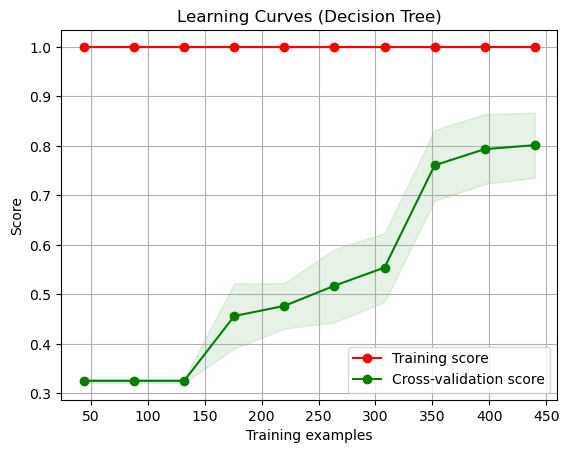

In [14]:
# Function to plot learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Plot learning curve for the Decision Tree model
title = "Learning Curves (Decision Tree)"
cv = 10  # Number of folds in cross-validation
plot_learning_curve(model, title, X, y, cv=cv)
plt.show()

In [65]:
# Model training (using the wrapper class)
model = DecisionTreeClassifierWithTrees(random_state=42)
model.fit(X_train, y_train)  # Fit the model before creating the explainer

# SHAP value calculation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)



In [67]:
shap.summary_plot(shap_values, X_test[:, mask], feature_names=common_wavenumbers[mask].astype(str))



IndexError: boolean index did not match indexed array along dimension 1; dimension is 901 but corresponding boolean dimension is 4601